In [23]:
import os
import numpy as np
import pandas as pd
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix,
)
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

import psycopg
from dotenv import load_dotenv
load_dotenv()

from sklearn.linear_model import LinearRegression
from autofeat import AutoFeatClassifier
from sklearn.impute import SimpleImputer

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

TABLE_NAME = "clean_users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "feature_selection_intersection"
#EXPERIMENT_NAME = "feature_selection_union"
RUN_NAME = "feature_selection"
#REGISTRY_MODEL_NAME = "churn_model_sergey_sh_union"
REGISTRY_MODEL_NAME = "churn_model_sergey_sh_interc"
FS_ASSETS = "fs_assets"

In [11]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [12]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME} limit 1000")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]
df = pd.DataFrame(data, columns=columns)

df.head()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,...,Yes,Yes,No,No,Male,0,No,No,No,0
1,2,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,...,No,No,No,No,Female,0,No,No,No,1
2,3,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,...,Yes,No,Yes,Yes,Female,0,No,No,Yes,1
3,4,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,...,No,No,Yes,No,Male,0,No,Yes,Yes,0
4,5,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,DSL,...,No,No,No,No,Female,0,No,No,No,0


num imputer done
cat imputer done
dummies done
sfs done
sbs done
sfs/sbs fitted


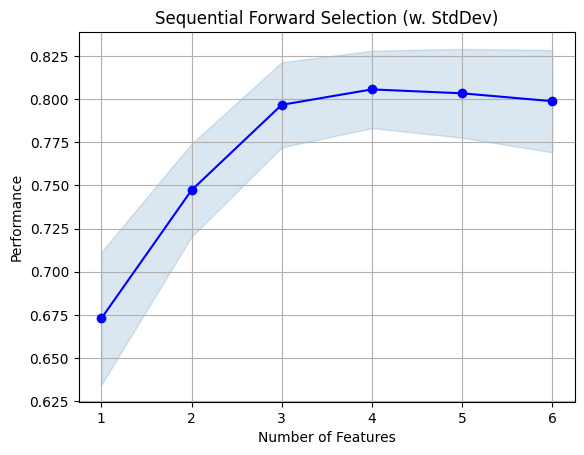

<Figure size 640x480 with 0 Axes>

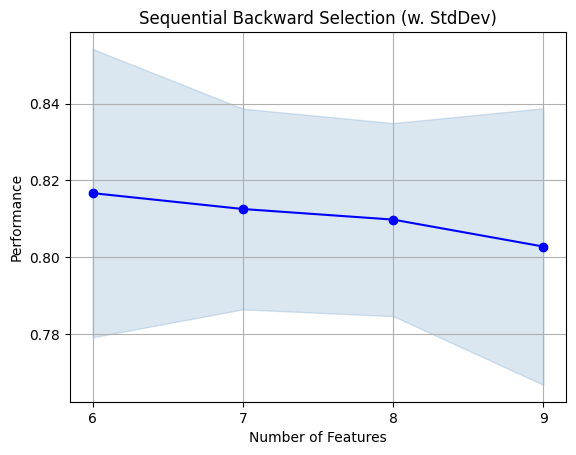

<Figure size 640x480 with 0 Axes>

In [13]:
TARGET_COL = "target"
cat_columns = ["type", "payment_method", "internet_service", "gender"]
num_columns = ["monthly_charges", "total_charges"]

X = df[cat_columns + num_columns]

y = df[TARGET_COL]

# --- Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Импутировать числа
num_imputer = SimpleImputer(strategy='median')
X_train[num_columns] = num_imputer.fit_transform(X_train[num_columns])
X_test[num_columns] = num_imputer.transform(X_test[num_columns])
print('num imputer done')

# Импутировать категории
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_columns] = cat_imputer.fit_transform(X_train[cat_columns])
X_test[cat_columns] = cat_imputer.transform(X_test[cat_columns])
print('cat imputer done')

# Преобразуем категории в дамми
X_train = pd.get_dummies(X_train, columns=cat_columns, drop_first=True)
X_test  = pd.get_dummies(X_test, columns=cat_columns, drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
print('dummies done')

assert X_train.isnull().sum().sum() == 0
assert X_test.isnull().sum().sum() == 0

from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

# 1. Оценщик: RandomForestClassifier (n_estimators=300)
estimator = RandomForestClassifier(n_estimators=100)

# 2. Sequential Forward Selection (SFS)
sfs = SFS(estimator, k_features=6, forward=True, floating=False, scoring='roc_auc', cv=4, n_jobs=-1)
print('sfs done')

# 3. Sequential Backward Selection (SBS)
sbs = SFS(estimator, k_features=6, forward=False, floating=False, scoring='roc_auc', cv=4, n_jobs=-1)
print('sbs done')

# 4. Обучение
sfs = sfs.fit(X_train, y_train)
sbs = sbs.fit(X_train, y_train)
print('sfs/sbs fitted')

# 5. Имена признаков
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

os.makedirs(FS_ASSETS, exist_ok=True)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png")

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))


In [14]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS)

2025-09-25 17:28:46,110 INFO: Found credentials in environment variables.


In [24]:
model = RandomForestClassifier()
# interc_features
model.fit(X_train[interc_features], y_train)
# union_features
#model.fit(X_train[union_features], y_train)

# Предсказания
prediction = model.predict(X_test[interc_features])
#prediction = model.predict(X_test[union_features])

# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, err2, _ = confusion_matrix(y_test, prediction,normalize='all').ravel()
#auc = roc_auc_score(y_test, probas)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
#metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_metrics(metrics)

    # Логируем полный пайплайн
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model_pipeline",
        registered_model_name=REGISTRY_MODEL_NAME
    )


/home/mle-user/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mle-user/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distu